In [19]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Evaluation
This notebook takes the preselection of candidate addresses and calculates the RC, AC and CCS scores to verify matching candidate addresses and vendor IDs. The results are divided in quantiles to improve comparability within the quantiles.

In [5]:
import pandas as pd
from neo4j import GraphDatabase
import time
import datetime
from datetime import timedelta
pd.set_option('display.max_colwidth', None)
from matplotlib import pyplot as plt

In [6]:
#Establish connection to Neo4j
df_pw = pd.read_csv("pw.csv", delimiter=",")
db = GraphDatabase.driver("neo4j://127.0.0.1:7687", auth=(df_pw["name"][0], df_pw["password"][0]))
session = db.session()

In [7]:
#Load all positive BM reviews
berlusconi_reviews = pd.read_csv('reviews_price_btc.csv')
berlusconi_reviews.time = pd.to_datetime(berlusconi_reviews.time)

In [8]:
berlusconi_reviews = berlusconi_reviews.merge(berlusconi_reviews.groupby("vendor_id").count()[["time"]].rename(columns={"time":"reviews"}), on="vendor_id")
berlusconi_reviews = berlusconi_reviews.rename(columns={"price_btc_reviews_satoshi":"review_amount"})

In [20]:
quantiles = {}
quantiles[1] = pd.DataFrame()
ctr = 1
last = 0
for i, entry in berlusconi_reviews[["vendor_id", "reviews"]].drop_duplicates().sort_values(by="reviews").iterrows():
    if (len(quantiles.get(ctr)) < 50):
        temp = pd.DataFrame({"vendor_id":[entry.vendor_id], "reviews":[entry.reviews]})
        quantiles[ctr] = pd.concat([quantiles[ctr], temp])
        last = entry.reviews
    else:
        if last == entry.reviews:
            temp = pd.DataFrame({"vendor_id":[entry.vendor_id], "reviews":[entry.reviews]})
            quantiles[ctr] = pd.concat([quantiles[ctr], temp])
        else:
            ctr = ctr+1
            quantiles[ctr] = pd.DataFrame({"vendor_id":[entry.vendor_id], "reviews":[entry.reviews]})

In [10]:
for quantile in quantiles:
    print (len(quantiles[quantile]))

72
65
56
52
50
50
52
50
50
39


In [11]:
#Load candidate addresses and filter to attain a preselection for the evaluation
candidate_addresses = pd.read_csv("all_candidates2.csv")
candidate_addresses[candidate_addresses["VA_HarmonicMean"] >= 0.005]

,Unnamed: 0,VendorID,VendorAddress,vendor_address_matches,all_vendor_matches,all_address_matches,#VA/#A,#VA/#V,VA_HarmonicMean
0,0,00f95a452f9befceeb8760095179ae28,127t48G4DN8JeoiTDjbST8e1SWPWJL6bUe,2,406,5,0.400000,0.004926,0.009732
4,4,00f95a452f9befceeb8760095179ae28,12YEsedPQtNff9ECSs7y2XS1DSngy8aCT7,2,406,2,1.000000,0.004926,0.009804
5,5,00f95a452f9befceeb8760095179ae28,13XAovM1xoeVabVbNKq5YUk8Sb8JUL8agR,2,406,2,1.000000,0.004926,0.009804
6,6,00f95a452f9befceeb8760095179ae28,13assTXavqBmC9mggChbCJvvzS6UrsGB1Z,2,406,13,0.153846,0.004926,0.009547
13,13,b82bcfb98686f6f435e5b99e21de0472,13assTXavqBmC9mggChbCJvvzS6UrsGB1Z,1,304,13,0.076923,0.003289,0.006309
...,...,...,...,...,...,...,...,...,...
1648347,1648347,fda88ee21f32bc07c718c8ae2091850f,3QYUSMk8wznmfYSvs6CRcgX33UriFAdbW2,6,208,6,1.000000,0.028846,0.056075
1648348,1648348,fda88ee21f32bc07c718c8ae2091850f,3QehYiXNu8aCKadN6QA3xn5hx7ZjFcXG3V,1,208,1,1.000000,0.004808,0.009569
1648349,1648349,fda88ee21f32bc07c718c8ae2091850f,3QtZbDGdyDEYnu4zM2Endrp41S4e64j7wW,1,208,1,1.000000,0.004808,0.009569
1648359,1648359,ffbc12fe270856d179c87b44c0083692,34GTuRAzHE91KxoKUhtkcaWzYg2ZAKwkm2,1,37,1,1.000000,0.027027,0.052632


In [12]:
#Final evaluation
evaluation = pd.DataFrame()
ctr = 0

#For all candidate address + vendor id pairs: Query for all TAs pointing to the candidate and matching the BM pattern.
for i in candidate_addresses[candidate_addresses["VA_HarmonicMean"] >= 0.005].itertuples():
    ctr = ctr + 1
    candidate = i.VendorAddress
    vendor = i.VendorID
    observedChange = str(0.01 * 100000000)

    neo_results = []
    neo_results2 = []
    neo_results3 = []

    #Query for all TAs pointing to the current candidate and matching the BM pattern. Returns amount and date of all matches
    neo_query = session.run("""
    WITH 
    '""" + candidate + """' as vendorCandidate,
    """ + observedChange + """ as usualChange
    MATCH (payout:Transaction)-[RECEIVES]->(vendor:Address)
    WHERE vendor.address = vendorCandidate and payout.outDegree = 2 and vendor.totalMoneyReceived < 6000000000
    WITH payout, usualChange, vendor
    MATCH (in:Address)-[SENDS]->(payout)-[r1:RECEIVES]->(change1:Address)
    WHERE 0.85 * usualChange <= r1.value <= 1.15 * usualChange 
    AND change1 <> vendor
    AND (change1.address STARTS WITH "3" OR change1.address STARTS WITH "bc1")
    AND (in.address STARTS WITH "3" OR in.address STARTS WITH "bc1")
    WITH payout, vendor
    MATCH (payout)-[r:RECEIVES]->(vendor)
    RETURN DISTINCT r.value, payout.date, payout.txid
    """)

    for r in neo_query:
        neo_results.append(r[0])
        neo_results2.append(r[1])
        neo_results3.append(r[2])

    if neo_results:        
        W = pd.DataFrame()        
        W["payoutAmount"] = pd.Series(neo_results)
        W["payoutDate"] = pd.Series(neo_results2)
        W["payoutTxid"] = pd.Series(neo_results3)

    #Select reviews belonging to current vendor id.
    R=berlusconi_reviews[berlusconi_reviews['vendor_id']==vendor][["vendor_review_id", "review_amount", "time"]]
    R.reset_index(drop=True, inplace = True)
    RcutW = pd.DataFrame()

    #For every payout TA in A: Check whether a matching BM review exists in R. Gather matches in RcutW.
    for idx, payout in W.iterrows():
        for idx2, review in R.iterrows():
            if (review.time.date() + timedelta(days=1) <= payout.payoutDate <= review.time.date() + timedelta(days=3)) & (0.8 * review.review_amount <= payout.payoutAmount <= 1.05 * review.review_amount):
                temp = pd.DataFrame({"ReviewID": [review.vendor_review_id], "payoutDate": [payout.payoutDate],"reviewDate": [pd.to_datetime(review.time).date()], "payoutAmount": [payout.payoutAmount],"reviewAmount": [review.review_amount],"payoutTxid": [payout.payoutTxid]})
                RcutW = pd.concat([RcutW, temp])
                
    RcutW = RcutW.reset_index(drop=True)

    #RcutW consists of every possible review, payout match 
    #including multiple payouts for one review and multiple reviews for on payout.
    #Take the review, payout match that removes the least other matches until only 1 match per review and payout is left
    maxVendorReviewMatches = pd.DataFrame()
    while(True):
        if (len(RcutW) == 0):
            break
        length = 0
        rev = ""
        txid = ""
        for idx, i in RcutW.iterrows():
            copy = RcutW.copy()
            copy = copy[copy["ReviewID"] != i.ReviewID]
            copy = copy[copy["payoutTxid"] != i.payoutTxid]
            if length == 0:
                length = len(copy)
                rev = i.ReviewID
                txid = i.payoutTxid
            elif (len(copy) > length):
                length = len(copy)
                rev = i.ReviewID
                txid = i.payoutTxid

        append = RcutW[RcutW["ReviewID"] == rev]
        maxVendorReviewMatches = pd.concat([maxVendorReviewMatches, append[append["payoutTxid"] == txid]])
        #print("maxVendorReviewMatches")
        #display(maxVendorReviewMatches)
        remove = RcutW[RcutW["ReviewID"] == rev]
        remove = remove[remove["payoutTxid"] == txid]
        #print(remove)
        RcutW = RcutW[~RcutW["payoutTxid"].isin(remove["payoutTxid"].values)]
        RcutW = RcutW[~RcutW["ReviewID"].isin(remove["ReviewID"].values)]
        #print("RcutW")
        #display(RcutW)
        #print("-----------------------------------------------------------")

    RC = len(maxVendorReviewMatches)/len(R)
    AC = len(maxVendorReviewMatches)/len(W)
    if (AC == 0) and (RC == 0):
        CCS = 0
    else:
        CCS=(2*RC*AC)/(RC+AC) 

    #Prepare output DataFrame
    temp = pd.DataFrame({"VendorID":[vendor], "CandidateAddress":[candidate], "RC":[RC], "AC":[AC], "CCS":[CCS]})
    evaluation = pd.concat([evaluation, temp])
    if ctr % 10 == 0:
        evaluation.to_csv("evaluation4.csv")
        
# Final save
evaluation.to_csv("evaluation4.csv")

In [21]:
# put evaluation results into correct quantiles
for i in quantiles:
    quantiles[i] = pd.merge(evaluation, quantiles[i], left_on="VendorID", right_on="vendor_id")
    quantiles[i].drop(columns=["vendor_id"])

818


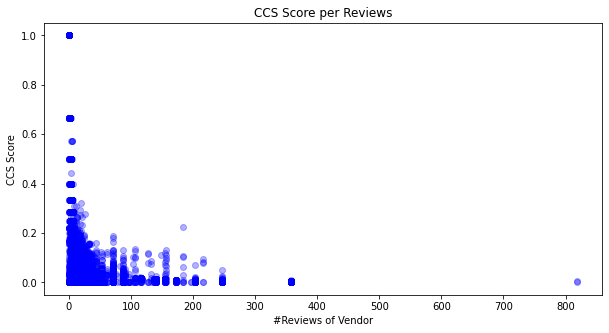

In [44]:
plt.figure(figsize=(10, 5))
max_r = 0
for i in quantiles:
    plt.scatter(x=quantiles[i]["reviews"],y=quantiles[i]["CCS"],c="blue",alpha=0.3)
    if quantiles[i]["reviews"].max() > max_r:
        max_r = quantiles[i]["reviews"].max()
plt.title("CCS Score per Reviews")
plt.xlabel("#Reviews of Vendor")
plt.ylabel("CCS Score")
plt.plot()
print(max_r)

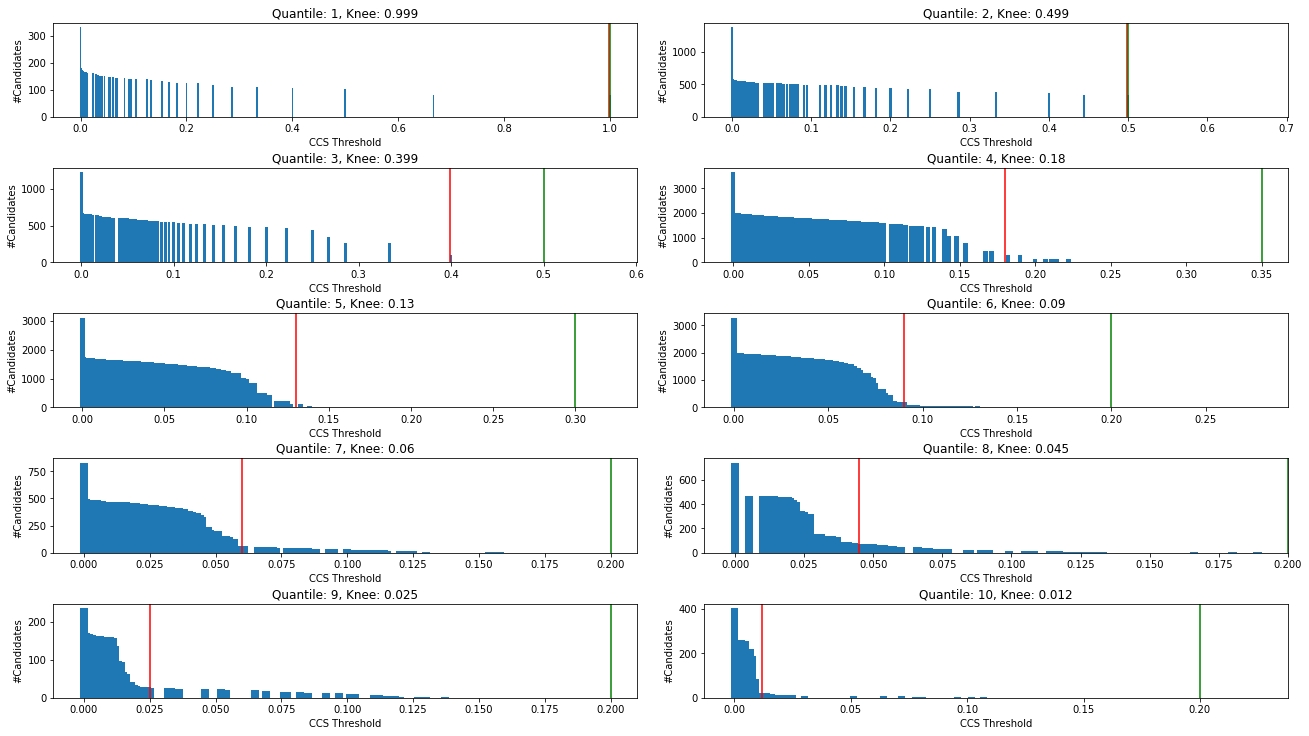

In [14]:
# check for knee value of CCS scores to determine quantile dependent thresholds
fig, axs = plt.subplots(5, 2)
fig.set_size_inches(18.5, 10.5)
fig.tight_layout(pad=3.0)
plot_positions = [(0,0),(0,1),(1,0),(1,1),(2,0),(2,1),(3,0),(3,1),(4,0),(4,1)]
knee_positions = [0.999,0.499,0.399,0.18,0.13,0.09,0.06,0.045,0.025,0.012]
ccs_threshold = [1.0, 0.5, 0.5,0.35,0.3,0.2,0.2,0.2,0.2,0.2]
for i in quantiles:
    plotlist = list()
    xlist = quantiles[i].sort_values(by="CCS",ascending=True)["CCS"].round(3).unique()
    for X in xlist:
        df_plot = quantiles[i][quantiles[i]["CCS"] >= X]
        plotlist.append(len(df_plot))
    axs[plot_positions[i-1]].bar(x = xlist, height=plotlist,width=0.003)
    axs[plot_positions[i-1]].set_title('Quantile: ' + str(i) + ", Knee: " + str(knee_positions[i-1]))
    axs[plot_positions[i-1]].axvline(x=knee_positions[i-1],color='red')
    axs[plot_positions[i-1]].axvline(x=ccs_threshold[i-1],color='green')


for ax in axs.flat:
    ax.set(xlabel='CCS Threshold', ylabel='#Candidates')

In [16]:
# final filtering with quantile dependent thresholds:
# for knee values < 0.2, choose 0.2 
ccs_thresholds = [1.0,0.5,0.4,0.2,0.2,0.2,0.2,0.2,0.2,0.2]
# [1.0, 0.5, 0.5,0.35,0.3,0.2,0.2,0.2,0.2,0.2]
for i in quantiles:
    # get addresses with highest CCS score per vendor
    temp = quantiles[i].sort_values(by="CCS", ascending=False).merge(quantiles[i][quantiles[i]["CCS"]>=ccs_thresholds[i-1]].groupby("VendorID")["CCS"].max(),on=["VendorID","CCS"],how="inner")
    # for vendors with multiple top addresses:
    for vendor in temp["VendorID"].unique():
        # are there multiple entries with CCS = 1 for the same vendor?
        if temp[temp["VendorID"] == vendor]["CCS"].max() == 1 and len(temp[temp["VendorID"] == vendor]) > 1:
            temp = temp[temp["VendorID"] != vendor] # exclude that vendor
        # are all addresses plausible together?
        elif temp[temp["VendorID"] == vendor]["RC"].sum() > 1:
            temp = temp[temp["VendorID"] != vendor] # exclude that vendor
    # store filtered candidates
    quantiles[i] = temp[["VendorID","CandidateAddress","RC","AC","CCS","reviews"]]
    display(quantiles[i])

,VendorID,CandidateAddress,RC,AC,CCS,reviews
12,41ec0f1350266dd8b22bb2535cb5dc98,3LSG4dW8xhvXMrxa7LJUN28vAyGkSwC4KX,1.0,1.0,1.0,1
39,a14c137d3bab517d1ea897c8bb922af6,3FW2rWrRQhfCM1ptFen96644rjESgT1pxk,1.0,1.0,1.0,1
46,8433c2592dab6b513a2a62fe116d2e94,3Kfsw5pe3cTipZA7CMoWpHQXhjcj5BEjUL,1.0,1.0,1.0,1
47,98236a3d290e786fa9a2751b43a35f6e,1LCRZ7MetdzwHm1wzNJPMVoZF91ryx9hko,1.0,1.0,1.0,1
54,dc30bc0c7914db5918da4263fce93ad2,1My4BZTaHX2k8sSpAec6p3qoGikgGhYcDJ,1.0,1.0,1.0,1
68,dfddc3e0679b86b804a5e2bfa0819e49,3QfERLojMyhgV733xu6xjgcFBAgx9dBcpz,1.0,1.0,1.0,1


,VendorID,CandidateAddress,RC,AC,CCS,reviews
119,a5fd7e58c9a7aef6935224676c4df5aa,3PfmYsBJf67r8NGxeNb1KCdkeNUuu8vBj6,0.666667,0.666667,0.666667,3


,VendorID,CandidateAddress,RC,AC,CCS,reviews
0,1b3fe873430563d8ad26d93327b9652c,3Q8QGEh4xBJZjSDoM4CVKv3sjKoDSaktSN,0.500000,0.666667,0.571429,4
1,b03786703e66800b109656fd1dcd9892,37vsjLhEgUm4QJGJBtbc2TgC6X5Kf2mm1C,0.400000,1.000000,0.571429,5
2,b03786703e66800b109656fd1dcd9892,1AjbUhCAnpwiouSVEhS3dJnQyUsAh5Y7ZD,0.400000,1.000000,0.571429,5
3,fd6a47385be1eec1e65090a8df001393,32hF16DDWF9TRyvvKMD3wWfvC5uTLGZbbz,0.400000,1.000000,0.571429,5
27,73a446ad3b830a0a059c51ed1b604e51,3HaHchKGMSxSLpE6Bm8jdUVVT9tTHJ4jds,0.285714,0.666667,0.400000,7
90,6dfc0fd8af3d7fbb55b6bcaaf42a3dd4,13nE1AmWGCre4EpAQvyxmEReJEceVV41G1,0.250000,1.000000,0.400000,4
91,6dfc0fd8af3d7fbb55b6bcaaf42a3dd4,1G13KKv1wrZ8MaMXGLUFvrjzXC54T3Vs3Q,0.250000,1.000000,0.400000,4


,VendorID,CandidateAddress,RC,AC,CCS,reviews
0,d77858bc92ea0d0ffbcdefcf4df6b121,1FNAyCsEvhufZRt5zQ98U71BaeKoWD5dYh,0.181818,1.000000,0.307692,11
1,f99440b7720f5ed2feffab4894aa03bd,35UiccUgoLCYUNMNkoTknScoHqzpTMNEtm,0.222222,0.500000,0.307692,9
2,f3c9e91dfd52b9dbf11644635626dc29,197VasiaRKUHXU11aBcuZvMDUFa3gCRyyX,0.250000,0.333333,0.285714,8
3,ac14525b3345931baaac32d56313a866,1CAHDxBLXUEqYXuinueXzmjtYjEUKA5Nyt,0.222222,0.400000,0.285714,9
4,05315b850efb9d7c4f3843934a64dd42,14cyBPumxpw4eiwRf67Mw28ty5FrGFBk5d,0.153846,1.000000,0.266667,13
5,05315b850efb9d7c4f3843934a64dd42,3Bjxof1RfEv31XtPvuo5Mzm1Qn83j78YuM,0.153846,1.000000,0.266667,13
6,5866e44c5047968bedd5ae9ea0187253,3GoHGjjpGuKGkTegyvLf9iRUKBjsCTi55k,0.230769,0.300000,0.260870,13
7,601d46d26f40abba6d7b168f33c14655,1KorskpACVJpoqA75SJWfJiGMPz5oc5H1V,0.181818,0.400000,0.250000,11
8,0e2e1fba7c397eb48fa516d08cb15450,1ABqBzTBKpUdA5XMAqFt6847iw6QHM7rbg,0.272727,0.214286,0.240000,11
9,675a17fea241474f4afc16e76a08d40c,1KgmGeowzvRZjE6tJy3DbNiu4KR6Pkj1Qd,0.222222,0.250000,0.235294,9


,VendorID,CandidateAddress,RC,AC,CCS,reviews
0,8fa68da5be518435847cb59e53b09f83,3BHxA9CUscBWCvgbUTVd4eBqqfpWFXmazd,0.210526,0.666667,0.320000,19
1,7cfdafca2f807054ebe02cde00e7013f,166sj9dMesjmQvU8vq3SRh3SuuUi3NPe8b,0.277778,0.312500,0.294118,18
2,f098a932b34eb84fca372e7ba690c851,3J7yVJoSAJSUtPGqcZFDELgjyqVvRS3rca,0.166667,0.750000,0.272727,18
3,17ab77b2f58f5110152f5ea89cb04166,1D3c5Kr2YVpiPBgqoDg1PtD2sMXvqCksp4,0.125000,0.666667,0.210526,16
4,44aa49f62a762cc95072955be3974939,3BMEXe9sq1idzNiLksC13Y8RDD8dTzAs9m,0.150000,0.333333,0.206897,20


,VendorID,CandidateAddress,RC,AC,CCS,reviews
0,f4f40ab623e3b612b6b2a25b163edcea,157aMyXrfUkX7nq7UdHoMKyjKHoEsYq3SQ,0.192308,0.500000,0.277778,26
1,ef243b9fed6d6c622c3a95475276a303,129SWv4e5rF2nNzr6GAnYaQ1N6S4hAgV2V,0.190476,0.444444,0.266667,21


,VendorID,CandidateAddress,RC,AC,CCS,reviews


,VendorID,CandidateAddress,RC,AC,CCS,reviews


,VendorID,CandidateAddress,RC,AC,CCS,reviews


,VendorID,CandidateAddress,RC,AC,CCS,reviews
0,ccd37b866b1e3ef007001e0c1a44c00e,195QZkhhKcodKbZvmTfWL1nsEx3Hajk2NK,0.255435,0.200855,0.22488,184


In [17]:
# store all final results in one csv file
results = pd.DataFrame()
for i in quantiles:
    results = pd.concat([results,quantiles[i]])
results.to_csv("final_results.csv")